## Imports

In [1]:
import json
import os
import time
from datetime import datetime
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib.patches import Patch

In [2]:
sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)
sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)

colors = ["#073b4c", "#ffd166", "#06d6a0", "#118ab2", "#ef476f", "#fb5607"]
patterns = ["/", "\\", "-", "+", "x", "o", "O", ".", "*", "|"]
markers = ["o", "s", "D", "^", "v", "*", "X", "+", "p", "h"]

## Get poster record from repositories

Get a list of all the posters along with their metadata from Zenodo and Figshare (posters published on the repositories as of December 31, 2024).
Note: The output of these functions are included in the dataset associated with this work

### Get poster record from Zenodo

In [3]:
# token
zenodo_access_token = os.getenv("ZENODO_ACCESS_TOKEN")

In [9]:
# Zenodo doesn't return more than 10k results per request so need to break down into date ranges with less than 10k posters created each
date_range_list = [
    "{* TO 2020-12-31]",
    "[2021-01-01 TO 2022-12-31]",
    "[2023-01-01 TO 2024-12-31]",
]

dict_results = {}
count = 0
for date_range in date_range_list:

    increment_page = True
    page = 0

    while increment_page:
        page += 1
        params = {
            "resource_type": "poster",
            "q": "created:" + date_range,
            "status": "published",
            "sort": "mostrecent",
            "all_versions": "false",
            "size": 300,
            "page": page,
            "access_token": zenodo_access_token,
        }
        response = requests.get(
            "https://zenodo.org/api/records",
            params=params,
        )

        if response.status_code == 200:
            r = response.json()
            if r["hits"]["hits"]:

                results = r["hits"]["hits"]

                for result in results:
                    dict_results[count] = result
                    count += 1
            else:
                print("No more pages", response.status_code, str(page))
                increment_page = False

        else:
            print("Error", response.status_code, response.content, str(page))
            increment_page = False
print(str(len(dict_results)), "posters were published on Zenodo as of December 31, 2024")
with open("outputs/records/zenodo.json", "w", encoding="utf-8") as f:
    json.dump(dict_results, f, ensure_ascii=False, indent=4)

No more pages 200 26
No more pages 200 27
No more pages 200 34
24751 posters were published on Zenodo as of December 31, 2024


#### Notes:  
- Role of researchers are not shown on the online record or the api record: why ask it?
- Additional dates: The dates are shown in the online record but not included in the api record, why?
- publication_date: provided by user
- creation_date: date when the record was created (since we are only looking at the latest version, this is the creation date of the latest version)

### Get posters metadata from Figshare

In [3]:
# token
figshare_access_token = os.getenv("FIGSHARE_ACCESS_TOKEN")

In [37]:
# Inspired from the example available here https://help.figshare.com/article/how-to-use-the-figshare-api#search-ids
# get info of all the posters (unlike Zenodo, this doesn't return all the metadata for each poster
# so we do that only to get all the ids of the posters)
BASE_URL = "https://api.figshare.com/v2"
results = []

posted_after_list = ["2012-01-01", "2021-01-01"]
posted_before_list = ["2020-12-31", "2024-12-31"]

for posted_after, posted_before in zip(posted_after_list, posted_before_list):
    search_logic = (
        ":item_type:poster AND "
        + ":posted_after:"
        + posted_after
        + " AND :posted_before:"
        + posted_before
    )
    query = '{"search_for": "' + search_logic + '"}'
    y = json.loads(query)

    for j in range(1, 11):
        r = json.loads(
            requests.post(
                BASE_URL + "/articles/search?page_size=1000&page={}".format(j), params=y
            ).content
        )
        if r:
            results.extend(r)
        else:
            break

In [39]:
# use figshare ids to get full metadata of each poster
dict_results = {}
count = 0
for result in results:
    if isinstance(result, dict):
        figshare_id = result["id"]
        api_call_headers = {"Authorization": "token " + str(figshare_access_token)}
        r = requests.get(
            BASE_URL + "/articles/" + str(figshare_id), headers=api_call_headers
        )
        metadata = json.loads(r.text)
        dict_results[count] = metadata
        count += 1
        
print(str(len(dict_results)), "posters were published on Figshare as of December 31, 2024")
with open("outputs/records/figshare.json", "w", encoding="utf-8") as f:
    json.dump(dict_results, f, ensure_ascii=False, indent=4)

14381 posters were published on Figshare as of December 31, 2024


In [4]:
# add views and downloads stat (different endpoint: https://docs.figshare.com/#stats_totals)
with open("inputs/dataset/primary/repository-records/figshare.json", "r", encoding="utf-8") as file:
    results = json.load(file)

In [7]:
base_url = "https://stats.figshare.com/total"
total = len(results)
for i, result in enumerate(results.values(), 1):
    item_id = result["id"]
    figshare_id = result["id"]
    api_call_headers = {"Authorization": "token " + str(figshare_access_token)}
    stats = {}
    for counter in ["views", "downloads"]:
        url = f"{base_url}/{counter}/article/{item_id}"
        r = requests.get(url, headers=api_call_headers)
        count = json.loads(r.text)
        # Figshare returns a plain number as text, e.g., "1234"
        stats[counter] = count["totals"]
    result["stats"] = stats
    
    sys.stdout.write(f"\rProgress: {i}/{total}")
    sys.stdout.flush()
print("\nDone!")

Progress: 14381/14381
Done!


In [10]:
with open("outputs/repository-records/figshare-with-stats.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

## Process records for metadata analysis

Transform the records from the repositories into a common tabular format to faciliate analysis. Both records from Zenodo and Figshare are mapped to a common metadata naming.

### Zenodo

In [9]:
# load data
with open("inputs/dataset/primary/repository-records/zenodo.json", "r", encoding="utf-8") as file:
    results = json.load(file)

In [4]:
# view a record
display(results["0"])

{'created': '2020-12-31T17:47:25.041391+00:00',
 'modified': '2024-07-19T11:12:40.105840+00:00',
 'id': 4407772,
 'conceptrecid': '4407771',
 'doi': '10.5281/zenodo.4407772',
 'conceptdoi': '10.5281/zenodo.4407771',
 'doi_url': 'https://doi.org/10.5281/zenodo.4407772',
 'metadata': {'title': 'Deep Learning-based Object Detection for a Quality Control Application in the Sterilization Unit of a Hospital',
  'doi': '10.5281/zenodo.4407772',
  'publication_date': '2020-11-26',
  'description': '<p>Machine vision systems are emerging as increasingly popular solutions in automated quality and process control applications. By allowing non-contact, and therefore non-destructive inspection, techniques based on machine vision are especially suitable when correct handling of the object under inspection is critical. This is the quality control problem that we address in this work: it consists of the detection of a series of control elements that are placed in boxes and bags that contain the surgic

In [10]:
# zenodo record schema https://github.com/zenodo/zenodo/blob/master/zenodo/modules/records/jsonschemas/records/record-v1.0.0.json                                                                                                                                                                         if metadata["access_right"] == "open":
rows_list = []

for result in results.values():
    row_dict = {}
    metadata = result["metadata"]

    # id and links
    row_dict["doi"] = False
    if "doi" in result.keys():
        row_dict["doi"] = result["doi"]
    row_dict["doi_url"] = False
    if "doi_url" in result.keys():
        row_dict["doi_url"] = result["doi_url"]
    row_dict["repository_url"] = False
    if "links" in result.keys():
        if "self_html" in result["links"].keys():
            row_dict["repository_url"] = result["links"]["self_html"]

    # access right
    row_dict["is_open_access"] = False
    if "access_right" in metadata.keys():
        if metadata["access_right"] == "open":
            row_dict["is_open_access"] = True

    # authors
    authors_count = 0
    authors_affiliation_count = 0
    authors_familyname_count = 0
    authors_givennames_count = 0
    authors_gnd_count = 0
    authors_name_count = 0
    authors_orcid_count = 0

    if "creators" in metadata.keys():
        authors_list = metadata["creators"]
        authors_count = len(authors_list)
        for author in authors_list:
            if "affiliation" in author.keys():
                if author["affiliation"] != None:
                    if len(author["affiliation"].strip()) > 0:
                        authors_affiliation_count += 1
            if "familyname" in author.keys():
                if author["familyname"] != None:
                    if len(author["familyname"].strip()) > 0:
                        authors_familyname_count += 1
            if "givennames" in author.keys():
                if author["givennames"] != None:
                    if len(author["givennames"].strip()) > 0:
                        authors_givennames_count += 1
            if "gnd" in author.keys():
                if len(author["gnd"].strip()) > 0:
                    authors_gnd_count += 1
            if "name" in author.keys():
                if len(author["name"].strip()) > 0:
                    authors_name_count += 1
            if "orcid" in author.keys():
                if len(author["orcid"].strip()) > 0:
                    authors_orcid_count += 1

    row_dict["authors_count"] = authors_count
    row_dict["authors_affiliation_count"] = authors_affiliation_count
    row_dict["authors_familyname_count"] = authors_familyname_count
    row_dict["authors_givennames_count"] = authors_givennames_count
    row_dict["authors_gnd_count"] = authors_gnd_count
    row_dict["authors_name_count"] = authors_name_count
    row_dict["authors_orcid_count"] = authors_orcid_count
    
    if authors_count == 0:
        authors_affiliation_percentage = 0
        authors_orcid_percentage = 0
    else:
        authors_affiliation_percentage = authors_affiliation_count/authors_count * 100
        authors_orcid_percentage = authors_orcid_count/authors_count * 100
        
    row_dict["authors_affiliation_percentage"] = authors_affiliation_percentage
    row_dict["authors_orcid_percentage"] = authors_orcid_percentage

    # grants
    row_dict["has_funding_info"] = False
    if "grants" in metadata.keys():
        if len(metadata["grants"]) > 0:
            row_dict["has_funding_info"] = True

    # journal
    row_dict["has_journal"] = False
    if "journal" in metadata.keys():
        if len(metadata["journal"]) > 0:
            row_dict["has_journal"] = True

    # keywords free text
    row_dict["keywords_freetext_count"] = 0
    if "keywords" in metadata.keys():
        if len(metadata["keywords"]) > 0:
            row_dict["keywords_freetext_count"] = len(metadata["keywords"])

    # keywords controlled vocabularies
    row_dict["keywords_controlled_vocabularies_count"] = 0
    if "subjects" in metadata.keys():
        if len(metadata["subjects"]) > 0:
            row_dict["keywords_controlled_vocabularies_count"] = len(
                metadata["subjects"]
            )

    # language
    row_dict["has_language"] = False
    if "language" in metadata.keys():
        if len(metadata["language"]) > 0:
            row_dict["has_language"] = True

    # license
    row_dict["has_license"] = False
    row_dict["license_name"] = "NA"
    if "license" in metadata.keys():
        row_dict["has_license"] = True
        row_dict["license_name"] = metadata["license"]["id"]

    # conference
    row_dict["has_conference_acronym"] = False
    row_dict["has_conference_dates"] = False
    row_dict["has_conference_place"] = False
    row_dict["has_conference_session"] = False
    row_dict["has_conference_session_part"] = False
    row_dict["has_conference_title"] = False
    row_dict["has_conference_website"] = False
    if "meeting" in metadata.keys():
        conference_metadata = metadata["meeting"]

        if "acronym" in conference_metadata.keys():
            if len(conference_metadata["acronym"].strip()) > 0:
                row_dict["has_conference_acronym"] = True

        if "dates" in conference_metadata.keys():
            if len(conference_metadata["dates"].strip()) > 0:
                row_dict["has_conference_dates"] = True

        if "place" in conference_metadata.keys():
            if len(conference_metadata["place"].strip()) > 0:
                row_dict["has_conference_place"] = True

        if "session" in conference_metadata.keys():
            if len(conference_metadata["session"].strip()) > 0:
                row_dict["has_conference_session"] = True

        if "session_part" in conference_metadata.keys():
            if len(conference_metadata["session_part"].strip()) > 0:
                row_dict["has_conference_session_part"] = True

        if "title" in conference_metadata.keys():
            if len(conference_metadata["title"].strip()) > 0:
                row_dict["has_conference_title"] = True

        if "url" in conference_metadata.keys():
            if len(conference_metadata["url"].strip()) > 0:
                row_dict["has_conference_website"] = True

    # creation_date
    row_dict["has_creation_date"] = False
    row_dict["creation_date"] = "NA"
    if "created" in result.keys():
        if len(result["created"].strip()) > 0:
            row_dict["has_creation_date"] = True
            row_dict["creation_date"] = result["created"]

    # other dates:
    row_dict["has_other_dates"] = False
    row_dict["other_dates"] = "NA"
    if "dates" in metadata.keys():
        if len(metadata["dates"]) > 0:
            row_dict["has_other_dates"] = True
            dates_count = 0
            dates_info = ""
            for date in metadata["dates"]:
                if dates_count > 0:
                    dates_info += "; "
                dates_info += str(date)
                files_count += 1
            row_dict["other_dates"] = dates_info

    # references
    row_dict["references_no_identifiers_count"] = 0
    if "references" in metadata.keys():
        if len(metadata["references"]) > 0:
            row_dict["references_no_identifiers_count"] = len(metadata["references"])

    # related identifiers count
    row_dict["references_with_identifiers_count"] = 0
    if "related_identifiers" in metadata.keys():
        if len(metadata["related_identifiers"]) > 0:
            row_dict["references_with_identifiers_count"] = len(
                metadata["related_identifiers"]
            )

    # title
    row_dict["has_title"] = False
    if "title" in metadata.keys():
        if len(metadata["title"].strip()) > 0:
            row_dict["has_title"] = True

    # version
    row_dict["has_version"] = False
    if "version" in metadata.keys():
        if len(metadata["version"].strip()) > 0:
            row_dict["has_version"] = True
            
    # description
    row_dict["has_description"] = False
    if "description" in metadata.keys():
        description_strip = metadata["description"].strip()
        description_words = description_strip.split()
        row_dict["description_number_words"] = len(description_words)
        description_no_spaces = [char for char in description_strip if char != ' ']
        if len(metadata["description"].strip()) > 0:
            row_dict["has_description"] = True

    # files
    files = result["files"]
    files_names = ""
    files_count = 0
    for file in files:
        if files_count > 0:
            files_names += "; "
        files_names += str(file["key"])
        files_count += 1
    row_dict["files"] = files_names
    
    #views and downloads
    views = -1
    downloads = -1
    if "stats" in result.keys():
        stats = result["stats"]
        if "views" in stats.keys():
            views = stats["views"]
        if "downloads" in stats.keys():
            downloads = stats["downloads"]
    row_dict["views"] = views
    row_dict["downloads"] = downloads
    
    # add to list
    rows_list.append(row_dict)

# save
df = pd.DataFrame(rows_list)
df.to_csv("outputs/poster-metadata/zenodo.csv", index=False)

print("Normalized metadata record created for Zenodo")

Normalized metadata record created for Zenodo


### Figshare

In [4]:
# load data
with open("inputs/dataset/primary/repository-records/figshare.json", "r", encoding="utf-8") as file:
    results = json.load(file)

In [7]:
# view a record
display(results["0"])

{'files': [{'id': 21189957,
   'name': 'Poster.pdf',
   'size': 1261287,
   'is_link_only': False,
   'download_url': 'https://ndownloader.figshare.com/files/21189957',
   'supplied_md5': 'e81696496c2f3dfa956d6e9120bd7a12',
   'computed_md5': 'e81696496c2f3dfa956d6e9120bd7a12',
   'mimetype': 'application/pdf'}],
 'authors': [{'id': 8332707,
   'full_name': 'Özlem Atalay',
   'first_name': 'Özlem',
   'last_name': 'Atalay',
   'is_active': True,
   'url_name': '_zlem_Atalay',
   'orcid_id': ''}],
 'custom_fields': [],
 'figshare_url': 'https://figshare.com/articles/poster/A_Key_Actor_in_EMI_-_METU_English_Proficiency_Exam_Design_Implementation_Validation/11663130',
 'download_disabled': False,
 'description': 'This poster shows the steps from program evaluation to the creation and validation of an English Proficiency Exam (EPE) at an EMI institution in Turkey. Following a program evaluation\nand renewal study to investigate the effectiveness of the English\nLanguage education curricula

In [8]:
rows_list = []
for metadata in results.values():
    row_dict = {}

    # id and links
    row_dict["doi"] = False
    row_dict["doi_url"] = False
    if "doi" in metadata.keys():
        row_dict["doi"] = metadata["doi"]
        row_dict["doi_url"] = "https://doi.org/" + metadata["doi"]
    row_dict["repository_url"] = False
    if "url_public_html" in metadata.keys():
        row_dict["repository_url"] = metadata["url_public_html"]

    # access right
    row_dict["is_open_access"] = False
    if "is_public" in metadata.keys():
        if metadata["is_public"]:
            row_dict["is_open_access"] = True

    # authors
    authors_count = 0
    authors_affiliation_count = -1
    authors_familyname_count = -1
    authors_givennames_count = -1
    authors_gnd_count = -1
    authors_name_count = 0
    authors_orcid_count = 0
    if "authors" in metadata.keys():
        authors_list = metadata["authors"]
        authors_count = len(authors_list)
        for author in authors_list:
            if "full_name" in author.keys():
                if len(author["full_name"].strip()) > 0:
                    authors_name_count += 1
            if "orcid_id" in author.keys():
                if len(author["orcid_id"].strip()) > 0:
                    authors_orcid_count += 1

    row_dict["authors_count"] = authors_count
    row_dict["authors_affiliation_count"] = authors_affiliation_count
    row_dict["authors_familyname_count"] = authors_familyname_count
    row_dict["authors_givennames_count"] = authors_givennames_count
    row_dict["authors_gnd_count"] = authors_gnd_count
    row_dict["authors_name_count"] = authors_name_count
    row_dict["authors_orcid_count"] = authors_orcid_count
    
    if authors_count == 0:
        authors_orcid_percentage = 0
    else:
        authors_orcid_percentage = authors_orcid_count/authors_count * 100
        
    row_dict["authors_affiliation_percentage"] = 0 # affiliation not supported
    row_dict["authors_orcid_percentage"] = authors_orcid_percentage
    
    
    # grants
    row_dict["has_funding_info"] = False
    if "funding_list" in metadata.keys():
        if len(metadata["funding_list"]) > 0:
            row_dict["has_funding_info"] = True

    # journal
    row_dict["has_journal"] = "Not supported"

    # keywords free text
    row_dict["keywords_freetext_count"] = 0
    if "tags" in metadata.keys():
        if len(metadata["tags"]) > 0:
            row_dict["keywords_freetext_count"] = len(metadata["tags"])

    # keywords controlled vocabularies
    row_dict["keywords_controlled_vocabularies_count"] = -1

    # language
    row_dict["has_language"] = "Not supported"

    # license
    row_dict["has_license"] = False
    row_dict["license_name"] = "NA"
    if "license" in metadata.keys():
        row_dict["has_license"] = True
        row_dict["license_name"] = metadata["license"]["name"]

    # conference
    row_dict["has_conference_acronym"] = "Not supported"
    row_dict["has_conference_dates"] = "Not supported"
    row_dict["has_conference_place"] = "Not supported"
    row_dict["has_conference_session"] = "Not supported"
    row_dict["has_conference_session_part"] = "Not supported"
    row_dict["has_conference_title"] = "Not supported"
    row_dict["has_conference_website"] = "Not supported"

    # creation date
    row_dict["has_creation_date"] = False
    row_dict["creation_date"] = "NA"
    if "published_date" in metadata.keys():
        if len(metadata["published_date"].strip()) > 0:
            row_dict["has_creation_date"] = True
            row_dict["creation_date"] = metadata["published_date"]

    # other dates
    row_dict["has_other_dates"] = "Not supported"
    row_dict["other_dates"] = "NA"

    # references with no identifiers count
    row_dict["references_no_identifiers_count"] = -1

    # references with identifiers count
    row_dict["references_with_identifiers_count"] = 0
    if "related_materials" in metadata.keys():
        if len(metadata["related_materials"]) > 0:
            row_dict["references_with_identifiers_count"] = len(
                metadata["related_materials"]
            )

    # title
    row_dict["has_title"] = False
    if "title" in metadata.keys():
        if len(metadata["title"].strip()) > 0:
            row_dict["has_title"] = True

    # version
    row_dict["has_version"] = False
    if "version" in metadata.keys():
        row_dict["has_version"] = True
    
    # description
    row_dict["has_description"] = False
    if "description" in metadata.keys():
        description_strip = metadata["description"].strip()
        description_words = description_strip.split()
        row_dict["description_number_words"] = len(description_words)
        description_no_spaces = [char for char in description_strip if char != ' ']
        row_dict["description_number_characters"] = len(description_no_spaces)
        if len(metadata["description"].strip()) > 0:
            row_dict["has_description"] = True
    
    # files
    if "files" in metadata.keys():
        files = metadata["files"]
        files_names = ""
        files_count = 0
        for file in files:
            if files_count > 0:
                files_names += "; "
            files_names += str(file["name"])
            files_count += 1
        row_dict["files"] = files_names
        
    #views and downloads
    views = -1
    downloads = -1
    if "stats" in metadata.keys():
        stats = metadata["stats"]
        if "views" in stats.keys():
            views = stats["views"]
        if "downloads" in stats.keys():
            downloads = stats["downloads"]
    row_dict["views"] = views
    row_dict["downloads"] = downloads

    # save
    rows_list.append(row_dict)

# save
df = pd.DataFrame(rows_list)
df.to_csv("outputs/poster-metadata/figshare.csv", index=False)

print("Normalized metadata record created for Figshare")

Normalized metadata record created for Figshare


## User provided metadata analysis

### Import and combine data

In [9]:
df1 = pd.read_csv("inputs/dataset/derivative/poster-metadata/zenodo.csv")
df2 = pd.read_csv("inputs/dataset/derivative/poster-metadata/figshare.csv")
df1["repository"] = "Zenodo"
df2["repository"] = "Figshare"

In [10]:
display(df1)

,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,other_dates,references_no_identifiers_count,references_with_identifiers_count,has_title,has_version,has_description,files,views,downloads,repository
0,10.5281/zenodo.4407772,https://doi.org/10.5281/zenodo.4407772,https://zenodo.org/records/4407772,True,3,3,0,0,0,3,...,NaN,0,0,True,False,True,idisba2020_poster_30x40_Yao_Ortiz_Bonnin.pdf,125,73,Zenodo
1,10.5281/zenodo.4405835,https://doi.org/10.5281/zenodo.4405835,https://zenodo.org/records/4405835,True,5,5,0,0,0,5,...,NaN,0,0,True,False,True,17_Poster.pdf,72,149,Zenodo
2,10.5281/zenodo.4404729,https://doi.org/10.5281/zenodo.4404729,https://zenodo.org/records/4404729,True,7,0,0,0,0,7,...,NaN,0,0,True,False,True,x.f Lebanon 24.04.2019 raied (2).pdf,77,58,Zenodo
3,10.5281/zenodo.4402107,https://doi.org/10.5281/zenodo.4402107,https://zenodo.org/records/4402107,True,1,0,0,0,0,1,...,NaN,0,0,True,False,True,A_Chatterjee_PMT_ICARUS.mp4; AC_PMT_Poster_Neu...,120,108,Zenodo
4,10.5281/zenodo.4401815,https://doi.org/10.5281/zenodo.4401815,https://zenodo.org/records/4401815,True,3,0,0,0,0,3,...,NaN,0,0,True,False,True,Final_Zara_Bagdarian_Borexino_Spectral_Fit_238...,147,75,Zenodo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24746,10.5281/zenodo.7764108,https://doi.org/10.5281/zenodo.7764108,https://zenodo.org/records/7764108,True,1,1,0,0,0,1,...,NaN,0,0,True,False,True,Eslab2023_nhuelamo_final.pdf,9,6,Zenodo
24747,10.5281/zenodo.7735662,https://doi.org/10.5281/zenodo.7735662,https://zenodo.org/records/7735662,True,12,12,0,0,0,12,...,NaN,4,0,True,True,True,TINX_v4_2023_IDGFace2Face.pdf,126,78,Zenodo
24748,10.5281/zenodo.7733711,https://doi.org/10.5281/zenodo.7733711,https://zenodo.org/records/7733711,True,3,3,0,0,0,3,...,NaN,0,0,True,False,True,Healthy Soils Yr1 Poster BT PDF.pdf,43,21,Zenodo
24749,10.5281/zenodo.7721838,https://doi.org/10.5281/zenodo.7721838,https://zenodo.org/records/7721838,True,1,0,0,0,0,1,...,NaN,0,0,True,False,True,rhz.PNG,42,2,Zenodo


In [11]:
df = pd.concat([df1, df2], ignore_index=True)
print(len(df))

39132


### Completeness of general metadata

We define the following metadata provided by authors as "general metadata": Title, Version, License, Author name, Author affiliation, Author ORCID, Description, Keyword, Funding information, References

Based on our analysis of the metadata we know that the following general metadata are collected in  each repository (* = mandatory):
- Zenodo (all):  Title*, Version, License, Author name*, Author affiliation, Author ORCID, Description,Keyword, Funding information, References
- Figshare: Title*, License*, Author name*, Author ORCID, Description*, Keyword*, Funding information, References

The following metadata are not collected from users:
- Zenodo: all general are collected
- Figshare: Version (auto provided), Author affiliation

In [12]:
repository_list = ["Zenodo", "Figshare"]
repository_list_loop = [[x] for x in repository_list]
metadata_results_list = []

# Title is provided
repo_metadata = ["Title"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_title"] == True]) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Version is provided
repo_metadata = ["Version"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_version"] == True]) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# License is provided
repo_metadata = ["License"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_license"] == True]) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Name of at least one author is provided
repo_metadata = ["At least one author name"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["authors_count"] > 0]) / len(df_sub) * 100
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Affiliation for all authors is provided
repo_metadata = ["Affiliation for all authors"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["authors_affiliation_count"] == df_sub["authors_count"]])
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# ORCID for all authors is provided
repo_metadata = ["ORCID for all authors"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["authors_orcid_count"] == df_sub["authors_count"]])
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Description is provided
repo_metadata = ["Description"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_description"] == True]) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# At least one keyword is provided
repo_metadata = ["At least one keyword"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(
            df_sub[
                (df_sub["keywords_freetext_count"] > 0)
                | (df_sub["references_with_identifiers_count"] > 0)
            ]
        )
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Funding info is provided
repo_metadata = ["Funding information"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["has_funding_info"] == True])
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# At least one reference is provided
repo_metadata = ["At least one reference"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(
            df_sub[
                (df_sub["references_no_identifiers_count"] > 0)
                | (df_sub["keywords_controlled_vocabularies_count"] > 0)
            ]
        )
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

df_general_metadata = pd.DataFrame(
    metadata_results_list, columns=["Metadata"] + repository_list
)
display(df_general_metadata)

,Metadata,Zenodo,Figshare
0,Title,100.000000,100.000000
1,Version,7.575451,100.000000
2,License,98.440467,100.000000
3,At least one author name,100.000000,99.993046
4,Affiliation for all authors,79.370530,0.000000
5,ORCID for all authors,25.643408,14.832070
6,Description,96.145610,100.000000
7,At least one keyword,54.179629,100.000000
8,Funding information,19.389116,27.174744
9,At least one reference,7.531009,0.000000


In [13]:
#metadata policy of repo for plotting
zenodo_policy = {
    "Title": "mandatory",
    "Version": "optional",
    "License": "optional",
    "At least one author name": "mandatory",
    "Affiliation for all authors": "optional",
    "ORCID for all authors": "optional",
    "Description": "optional",
    "At least one keyword": "optional",
    "Funding information": "optional",
    "At least one reference": "optional",
}

figshare_policy = {
    "Title": "mandatory",
    "Version": "auto",
    "License": "mandatory",
    "At least one author name": "mandatory",
    "Affiliation for all authors": "not_collected",
    "ORCID for all authors": "optional",
    "Description": "mandatory",
    "At least one keyword": "mandatory",
    "Funding information": "optional",
    "At least one reference": "optional",
}

C:\Users\BPatel\AppData\Local\Temp\ipykernel_83292\859763121.py:36: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(min(f[i] + ypad, 102), x[i] + width/2, s=60, **stylef)


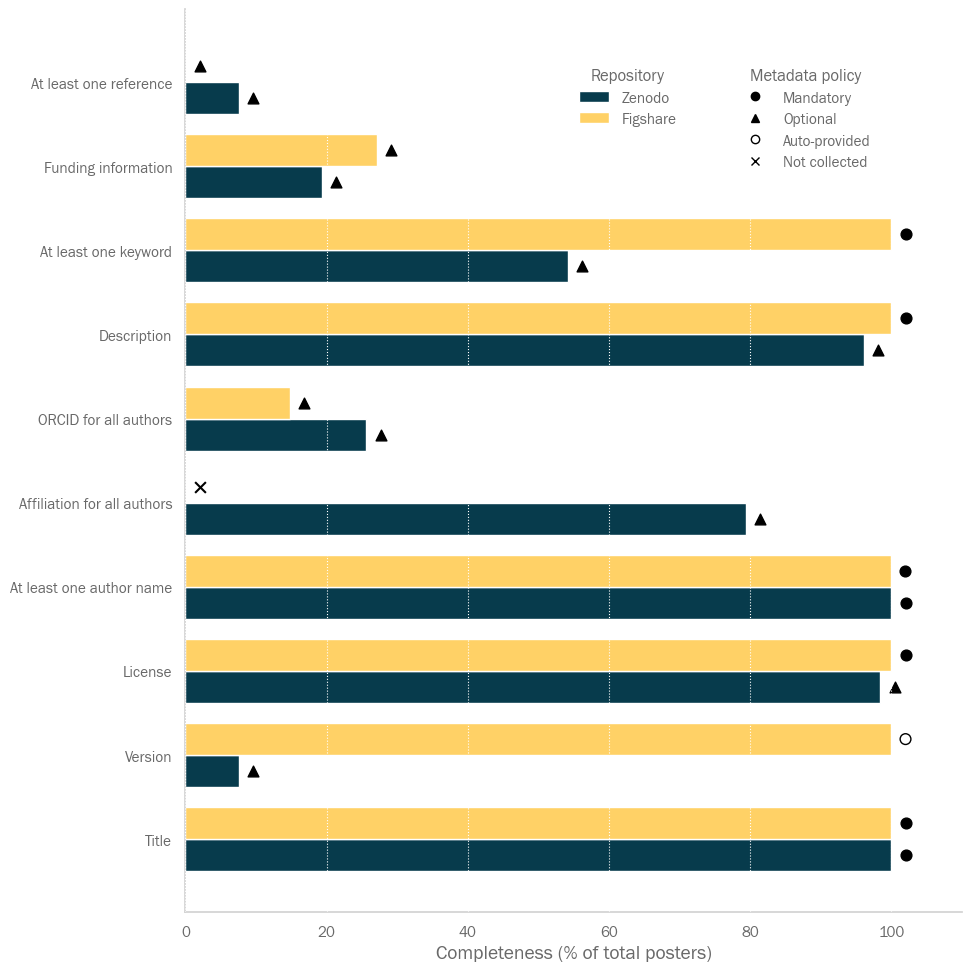

In [14]:
def policy_marker(policy):
    if policy == "mandatory":
        return dict(marker="o", facecolors="black", edgecolors="black")
    if policy == "auto":
        return dict(marker="o", facecolors="none", edgecolors="black") 
    if policy == "not_collected":
        return dict(marker="x", facecolors="black", edgecolors="black")
    return dict(marker="^", facecolors="black", edgecolors="black")  

def plot_metadata_completeness(df, zenodo_policy, figshare_policy):
    labels = df["Metadata"].tolist()
    z = df["Zenodo"].to_numpy()
    f = df["Figshare"].to_numpy()

    x = np.arange(len(labels))
    width = 0.38

    fig, ax = plt.subplots(figsize=(10, 10))

    # bars
    bz = ax.barh(x - width/2, z, width, label="Zenodo", color = colors[0])
    bf = ax.barh(x + width/2, f, width, label="Figshare", color = colors[1])

    # policy markers
    ypad = 2.0  # % points above bar

    for i, m in enumerate(labels):
        # Zenodo marker
        pz = zenodo_policy.get(m, "optional")
        stylez = policy_marker(pz)
        ax.scatter(min(z[i] + ypad, 102), x[i] - width/2, s=60, **stylez)

        # Figshare marker
        pf = figshare_policy.get(m, "optional")
        stylef = policy_marker(pf)
        ax.scatter(min(f[i] + ypad, 102), x[i] + width/2, s=60, **stylef)

    ax.set_xlim(0, 110)
    ax.set_xlabel("Completeness (% of total posters)", fontsize = 14)
    ax.set_yticks(x)
    ax.set_yticklabels(labels)

    # Repo legend
    bar_legend = ax.legend(
        loc="upper right",
        bbox_to_anchor=(0.65, 0.95),
        title="Repository",
        frameon=False
    )
    ax.add_artist(bar_legend)

    # Policy legend
    from matplotlib.lines import Line2D
    marker_handles = [
        Line2D([0], [0], marker='o', color='black', linestyle='None',
               markerfacecolor='black', label='Mandatory'),
        Line2D([0], [0], marker='^', color='black', linestyle='None',
               markerfacecolor='black', label='Optional'),
        Line2D([0], [0], marker='o', color='black', linestyle='None',
               markerfacecolor='none', label='Auto-provided'),
        Line2D([0], [0], marker='x', color='black', linestyle='None',
               label='Not collected'),
    ]
    ax.legend(handles=marker_handles, loc="center right", title="Repository policy")
    ax.legend(
        handles=marker_handles,
        loc="upper right",
        bbox_to_anchor=(0.9, 0.95),
        title="Metadata policy",
        frameon=False
    )
    ax.grid(axis="x", linestyle=":", linewidth=0.8)
    
    fig.tight_layout()
    return fig, ax


fig, ax = plot_metadata_completeness(df_general_metadata, zenodo_policy, figshare_policy)
plt.savefig('outputs/poster-metadata/completeness.png') 
plt.show()

### Completeness of conference related metadata on Zenodo

Only for Zenodo

In [15]:
conference_metadata_results_list = []

conference_cols = [
    "has_conference_acronym",
    "has_conference_dates",
    "has_conference_place",
    "has_conference_session",
    "has_conference_session_part",
    "has_conference_title",
    "has_conference_website",
]

repository_list = ["Zenodo"] # Only doing this for Zenodo
repository_list_loop = [[x] for x in repository_list]

# Conference name is provided
repo_metadata = ["Conference name"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_title"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference acronym is provided
repo_metadata = ["Conference acronym"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_acronym"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference dates are provided
repo_metadata = ["Conference dates"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_dates"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference location is provided
repo_metadata = ["Conference location"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_place"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference website is provided
repo_metadata = ["Conference website"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_website"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference session of the poster is provided
repo_metadata = ["Conference session related to the poster"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(
            df_sub[
                (df_sub["has_conference_session"] == True)
                | (df_sub["has_conference_session_part"] == True)
            ]
        )
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# At least one conference-related metadata is provided
df["has_any_conference_metadata"] = df[conference_cols].any(axis=1)
repo_metadata = ["Any conference-related metadata"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_any_conference_metadata"] == True])/ len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# All conference-related metadata is provided
df["has_all_conference_metadata"] = df[conference_cols].all(axis=1)
repo_metadata = ["All conference-related metadata"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_all_conference_metadata"] == True])/ len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

df_conference_metadata = pd.DataFrame(
    conference_metadata_results_list, columns=["Metadata"] + repository_list
)
display(df_conference_metadata)

,Metadata,Zenodo
0,Conference name,47.084966
1,Conference acronym,27.259505
2,Conference dates,44.854753
3,Conference location,40.935720
4,Conference website,37.347986
5,Conference session related to the poster,13.696416
6,Any conference-related metadata,47.557674
7,All conference-related metadata,1.591855


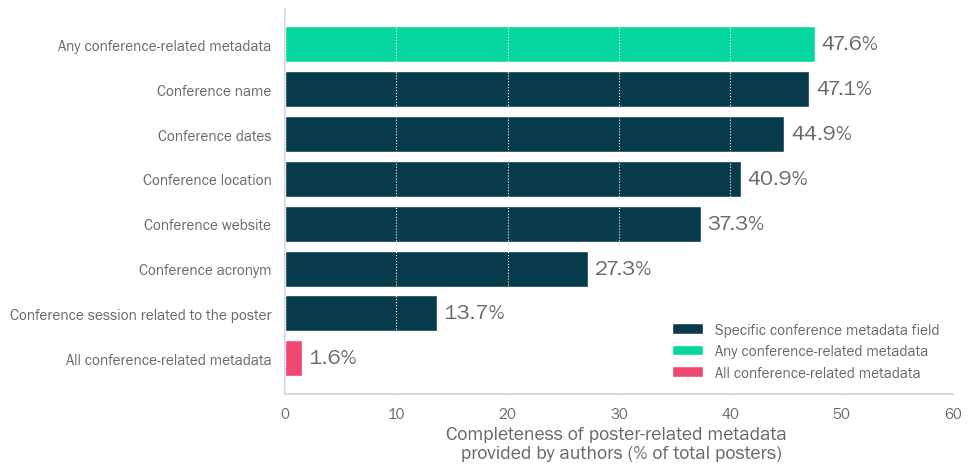

In [16]:
def plot_conference_metadata_zenodo(df_conf):
    dfp = df_conf.copy()

    # Sort by percentage
    dfp = dfp.sort_values("Zenodo", ascending=True).reset_index(drop=True)

    # Rows to highlight with different color
    is_any = dfp["Metadata"].str.strip().eq("Any conference-related metadata")
    is_all = dfp["Metadata"].str.strip().eq("All conference-related metadata")

    # Colors
    base_color = colors[0]      
    any_color = colors[2]       
    all_color = colors[4]      
    colors_assigned = []
    for m in dfp["Metadata"]:
        if m == "Any conference-related metadata":
            colors_assigned.append(any_color)
        elif m == "All conference-related metadata":
            colors_assigned.append(all_color)
        else:
            colors_assigned.append(base_color)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(dfp["Metadata"], dfp["Zenodo"], color=colors_assigned)

    # Add value at the end of bars
    for y, v in enumerate(dfp["Zenodo"].values):
        ax.text(v + 0.6, y, f"{v:.1f}%", va="center")
    
    # Axis
    ax.set_xlim(0, 60)
    ax.set_xlabel("Completeness of poster-related metadata \n provided by authors (% of total posters)",
                 fontsize = 14)

    # Light vertical grid lines over bars
    ax.grid(axis="x", linestyle=":", linewidth=0.8)

    # Legend
    legend_handles = [
    Patch(facecolor=base_color, label="Specific conference metadata field"),
    Patch(facecolor=any_color, label="Any conference-related metadata"),
    Patch(facecolor=all_color, label="All conference-related metadata"),
    ]
    ax.legend(handles=legend_handles, loc="lower right", frameon=False)

    fig.tight_layout()
    return fig, ax

fig, ax = plot_conference_metadata_zenodo(df_conference_metadata)
plt.savefig('outputs/poster-metadata/completeness-conference.png') 
plt.show()